# Healthcare Chatbot Model Training

This notebook trains and evaluates machine learning models for the healthcare chatbot system.
It includes data preprocessing, model training, performance evaluation, and model persistence.

## 1. Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load the training and testing data
print("Loading dataset...")
training = pd.read_csv('Data/Training.csv')
testing = pd.read_csv('Data/Testing.csv')

print(f"Training data shape: {training.shape}")
print(f"Testing data shape: {testing.shape}")
print(f"Number of symptoms: {len(training.columns) - 1}")
print(f"Number of diseases: {len(training['prognosis'].unique())}")

# Display basic information
print("\nFirst few rows of training data:")
training.head()

Loading dataset...
Training data shape: (4920, 133)
Testing data shape: (41, 133)
Number of symptoms: 132
Number of diseases: 41

First few rows of training data:


,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection


## 2. Data Preprocessing

In [11]:
# Separate features and target
cols = training.columns[:-1]  # All columns except 'prognosis'
X = training[cols]
y = training['prognosis']

# Encode target labels
le = preprocessing.LabelEncoder()
le.fit(y)
y_encoded = le.transform(y)

# Prepare test data
X_test_final = testing[cols]
y_test_final = le.transform(testing['prognosis'])

# Split training data for validation
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test_final.shape[0]} samples")

# Save label encoder for later use
joblib.dump(le, 'models/label_encoder.pkl')
print("Label encoder saved!")

Training set: 3936 samples
Validation set: 984 samples
Test set: 41 samples
Label encoder saved!


## 3. Model Training and Evaluation

In [5]:
# Initialize models
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(random_state=42),
    'Naive Bayes': GaussianNB()
}

# Train and evaluate models
model_results = {}
trained_models = {}

for name, model in models.items():
    print(f"Training {name}...")
    
    # Train model
    model.fit(X_train, y_train)
    trained_models[name] = model
    
    # Predictions
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test_final)
    
    # Calculate metrics
    val_accuracy = accuracy_score(y_val, y_pred_val)
    test_accuracy = accuracy_score(y_test_final, y_pred_test)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    
    model_results[name] = {
        'validation_accuracy': val_accuracy,
        'test_accuracy': test_accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'cv_scores': cv_scores
    }
    
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print('-' * 50)

Training Decision Tree...
Validation Accuracy: 1.0000
Test Accuracy: 1.0000
CV Score: 0.9995 (+/- 0.0020)
--------------------------------------------------
Training Random Forest...
Validation Accuracy: 1.0000
Test Accuracy: 1.0000
CV Score: 1.0000 (+/- 0.0000)
--------------------------------------------------
Training SVM...
Validation Accuracy: 1.0000
Test Accuracy: 1.0000
CV Score: 1.0000 (+/- 0.0000)
--------------------------------------------------
Training Naive Bayes...
Validation Accuracy: 1.0000
Test Accuracy: 1.0000
CV Score: 1.0000 (+/- 0.0000)
--------------------------------------------------


## 5. Model Performance Visualization

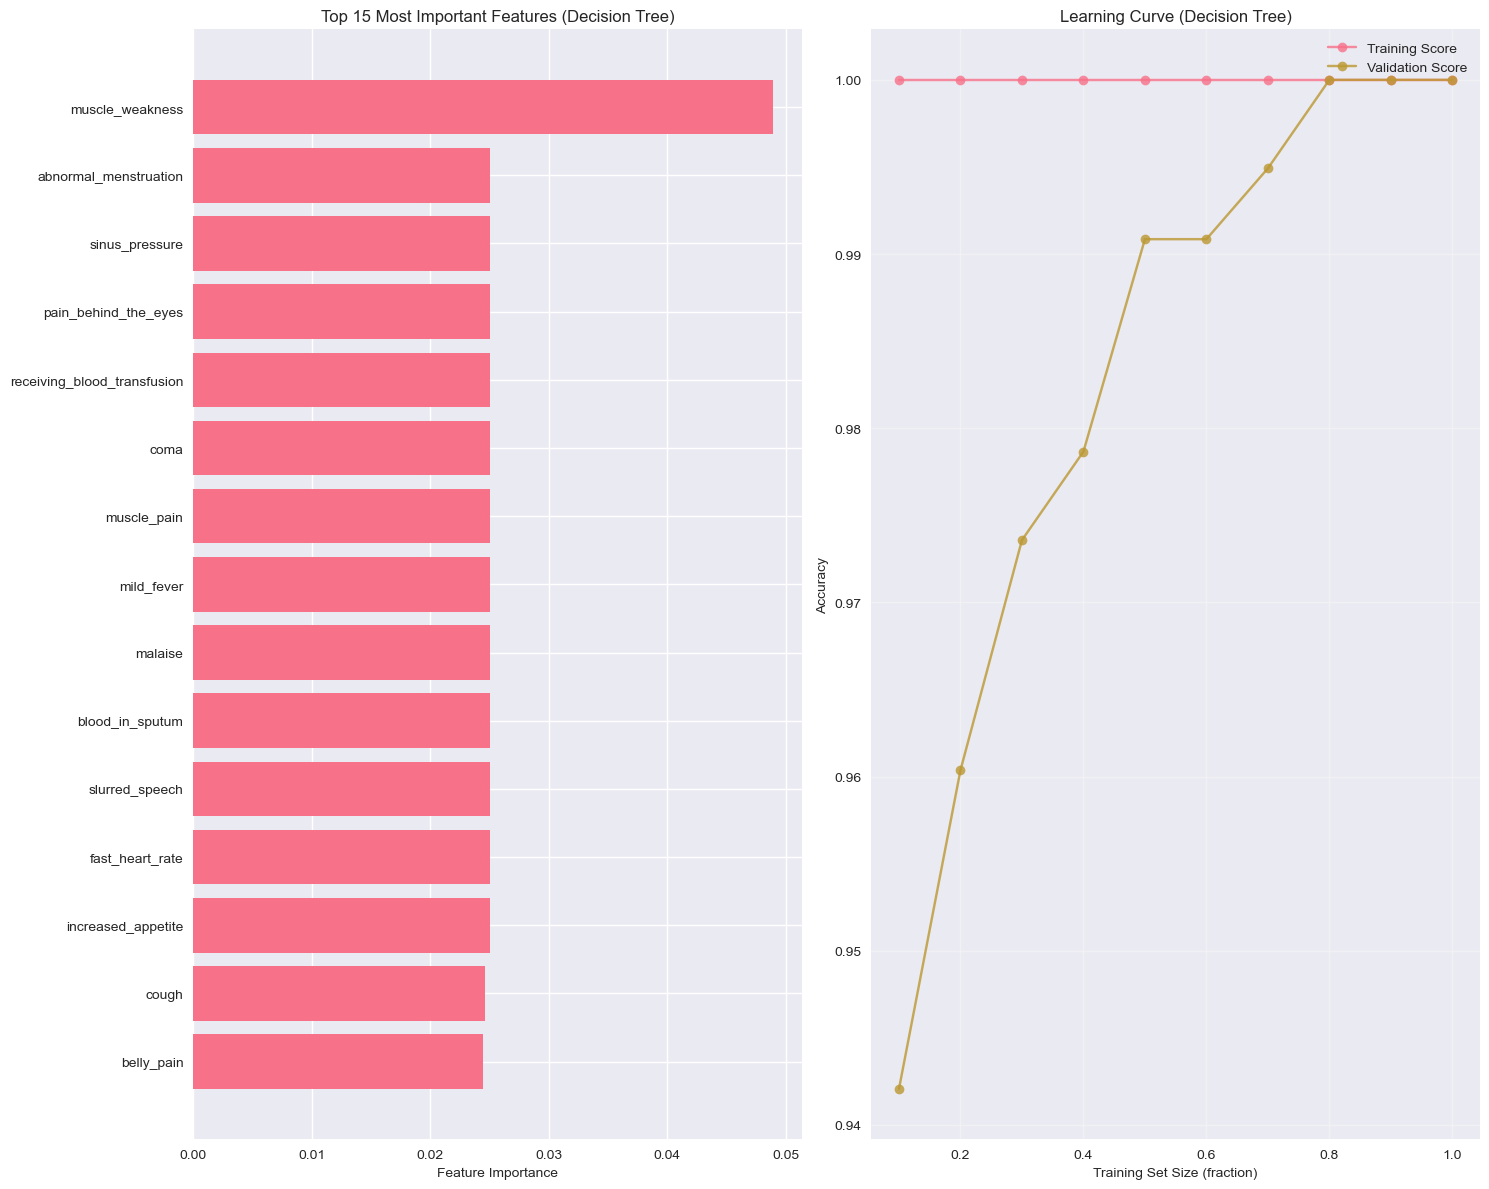

Best performing model: Decision Tree
Best test accuracy: 1.0000


In [8]:
# Create performance comparison plots
fig, axes = plt.subplots(1, 2, figsize=(15, 12))

# Accuracy comparison
model_names = list(model_results.keys())
val_accuracies = [model_results[name]['validation_accuracy'] for name in model_names]
test_accuracies = [model_results[name]['test_accuracy'] for name in model_names]

x = np.arange(len(model_names))
width = 0.35


# Feature importance for Decision Tree
dt_model = trained_models['Decision Tree']
feature_importance = dt_model.feature_importances_
top_features_idx = np.argsort(feature_importance)[-15:]  # Top 15 features
top_features_names = [cols[i] for i in top_features_idx]
top_features_importance = feature_importance[top_features_idx]

axes[0].barh(top_features_names, top_features_importance)
axes[0].set_xlabel('Feature Importance')
axes[0].set_title('Top 15 Most Important Features (Decision Tree)')

# Learning curve for best model
best_model_name = max(model_results.keys(), key=lambda k: model_results[k]['test_accuracy'])
best_model = trained_models[best_model_name]

# Simple learning curve
train_sizes = np.linspace(0.1, 1.0, 10)
train_scores = []
val_scores = []

for train_size in train_sizes:
    size = int(train_size * len(X_train))
    X_subset = X_train[:size]
    y_subset = y_train[:size]
    
    # Train on subset
    temp_model = type(best_model)(**best_model.get_params())
    temp_model.fit(X_subset, y_subset)
    
    train_score = temp_model.score(X_subset, y_subset)
    val_score = temp_model.score(X_val, y_val)
    
    train_scores.append(train_score)
    val_scores.append(val_score)

axes[1].plot(train_sizes, train_scores, 'o-', label='Training Score', alpha=0.8)
axes[1].plot(train_sizes, val_scores, 'o-', label='Validation Score', alpha=0.8)
axes[1].set_xlabel('Training Set Size (fraction)')
axes[1].set_ylabel('Accuracy')
axes[1].set_title(f'Learning Curve ({best_model_name})')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Best performing model: {best_model_name}")
print(f"Best test accuracy: {model_results[best_model_name]['test_accuracy']:.4f}")

## 6. Detailed Analysis of Best Model

Detailed Classification Report for Decision Tree:
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00         1
                                   AIDS       1.00      1.00      1.00         1
                                   Acne       1.00      1.00      1.00         1
                    Alcoholic hepatitis       1.00      1.00      1.00         1
                                Allergy       1.00      1.00      1.00         1
                              Arthritis       1.00      1.00      1.00         1
                       Bronchial Asthma       1.00      1.00      1.00         1
                   Cervical spondylosis       1.00      1.00      1.00         1
                            Chicken pox       1.00      1.00      1.00         1
                    Chronic cholestasis       1.00      1.00      1.00         1
                            Common Cold       1.00      1.

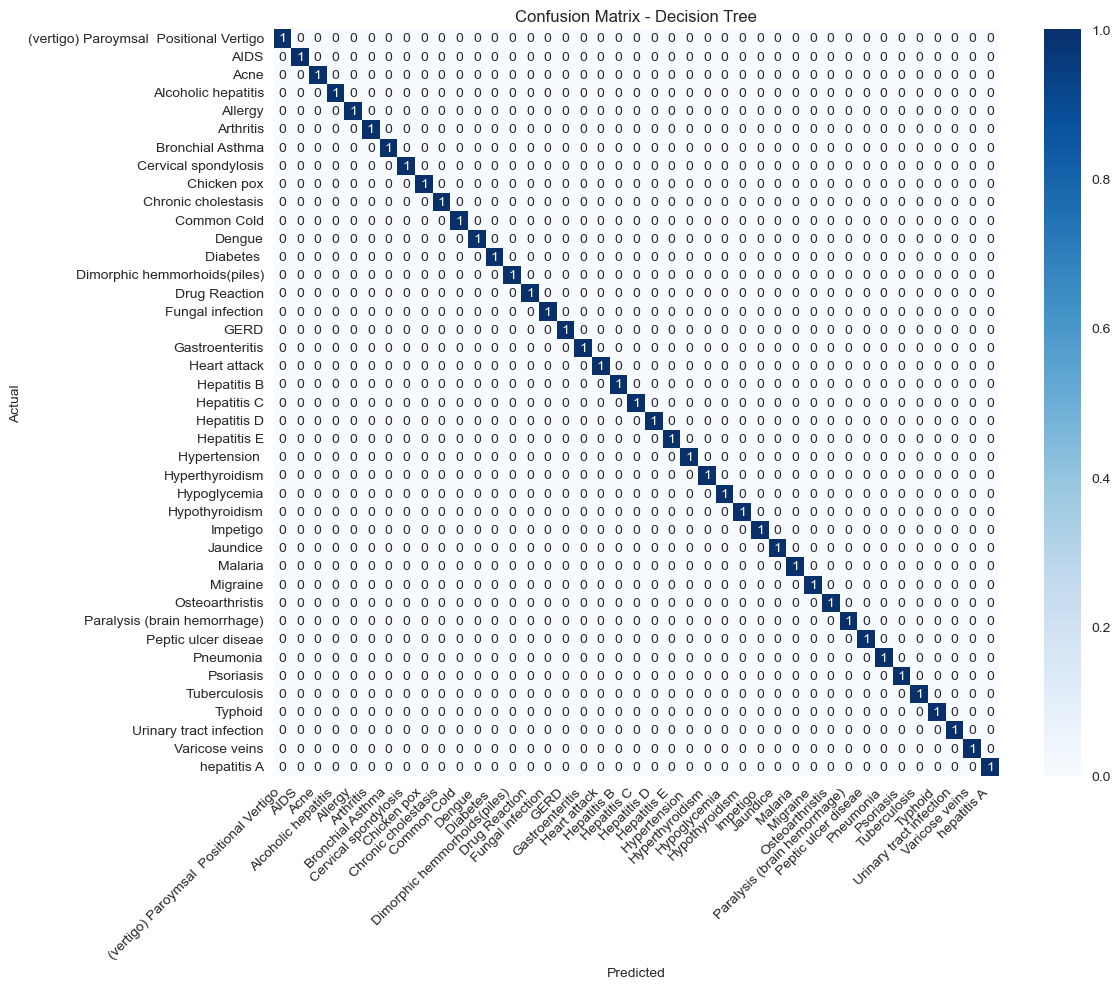


Per-class Performance (sorted by F1-Score):
                                Disease  Precision  Recall  F1-Score  Support
(vertigo) Paroymsal  Positional Vertigo        1.0     1.0       1.0        1
                            Hepatitis D        1.0     1.0       1.0        1
                          Hypertension         1.0     1.0       1.0        1
                        Hyperthyroidism        1.0     1.0       1.0        1
                           Hypoglycemia        1.0     1.0       1.0        1
                         Hypothyroidism        1.0     1.0       1.0        1
                               Impetigo        1.0     1.0       1.0        1
                               Jaundice        1.0     1.0       1.0        1
                                Malaria        1.0     1.0       1.0        1
                               Migraine        1.0     1.0       1.0        1
                        Osteoarthristis        1.0     1.0       1.0        1
           Paralysi

In [9]:
# Get the best model
best_model = trained_models[best_model_name]
y_pred_detailed = best_model.predict(X_test_final)

# Classification report
print(f"Detailed Classification Report for {best_model_name}:")
print(classification_report(y_test_final, y_pred_detailed, target_names=le.classes_))

# Confusion matrix visualization
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test_final, y_pred_detailed)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Per-class performance
precision, recall, f1, support = precision_recall_fscore_support(y_test_final, y_pred_detailed)

performance_df = pd.DataFrame({
    'Disease': le.classes_,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

# Sort by F1-score
performance_df = performance_df.sort_values('F1-Score', ascending=False)
print("\nPer-class Performance (sorted by F1-Score):")
print(performance_df.to_string(index=False))

## 7. Model Saving and Export

In [10]:
# Create models directory if it doesn't exist
import os
os.makedirs('models', exist_ok=True)

# Save the best model
model_filename = f'models/best_model_{best_model_name.lower().replace(" ", "_")}.pkl'
joblib.dump(best_model, model_filename)
print(f"Best model saved as: {model_filename}")

# Save feature names
feature_names_file = 'models/feature_names.pkl'
joblib.dump(list(cols), feature_names_file)
print(f"Feature names saved as: {feature_names_file}")

# Save model performance summary
summary = {
    'best_model': best_model_name,
    'test_accuracy': model_results[best_model_name]['test_accuracy'],
    'validation_accuracy': model_results[best_model_name]['validation_accuracy'],
    'cv_score_mean': model_results[best_model_name]['cv_mean'],
    'cv_score_std': model_results[best_model_name]['cv_std'],
    'feature_count': len(cols),
    'class_count': len(le.classes_),
    'training_samples': len(X_train),
    'test_samples': len(X_test_final)
}

joblib.dump(summary, 'models/model_summary.pkl')
print("Model summary saved as: models/model_summary.pkl")

# Create a simple performance report
print("\n=== TRAINING COMPLETE ===")
print(f"Best Model: {best_model_name}")
print(f"Test Accuracy: {model_results[best_model_name]['test_accuracy']:.4f}")
print(f"Cross-Validation Score: {model_results[best_model_name]['cv_mean']:.4f} ± {model_results[best_model_name]['cv_std']:.4f}")
print(f"Number of Features: {len(cols)}")
print(f"Number of Diseases: {len(le.classes_)}")
print("\nFiles saved:")
print(f"- {model_filename}")
print(f"- {feature_names_file}")
print("- models/label_encoder.pkl")
print("- models/model_summary.pkl")

Best model saved as: models/best_model_decision_tree.pkl
Feature names saved as: models/feature_names.pkl
Model summary saved as: models/model_summary.pkl

=== TRAINING COMPLETE ===
Best Model: Decision Tree
Test Accuracy: 1.0000
Cross-Validation Score: 0.9995 ± 0.0010
Number of Features: 132
Number of Diseases: 41

Files saved:
- models/best_model_decision_tree.pkl
- models/feature_names.pkl
- models/label_encoder.pkl
- models/model_summary.pkl
